# Parse LSDYNA file to extract particle coordinate, type, Von Mises Stree

In [3]:
import re
import numpy as np

LOADING_PARTICLES = []
SUPPORT_PARTICLES = []

def parse_simulation(file):
    with open(file, 'r') as f:
        lines = f.readlines()

    # Find all "particle position" lines and "plastic strain" lines using key words
    pos_lines_start, pos_lines_end = [], []
    strain_lines_start, strain_lines_end = [], []
    for idx, line in enumerate(lines):
        if line.startswith("*NODE"):
            pos_lines_start.append(idx)
        elif line.startswith("$NODAL_RESULTS"):  # $NODAL_RESULTS,(1d) *INITIAL_VELOCITY_NODE(2d)
            pos_lines_end.append(idx)
        elif line.startswith("$RESULT OF Effective Stress (v-m)"):
            strain_lines_start.append(idx)
        elif line.startswith("*END"):  
            strain_lines_end.append(idx)
            
    # Extact particle positions 
    trajectory = []
    for line_start, line_end in zip(pos_lines_start, pos_lines_end):
        pos_lines = lines[line_start+1:line_end]   # lines that contains positions in one time step
        timestep = []
        for line in pos_lines:
            num_str = re.findall(r'[-\d\.e+]+', line)  # Regular expression findign scitific numbers
            (x, y) = (float(num_str[1]), float(num_str[2]))
            timestep.append((x,y))
        trajectory.append(timestep) 
    
    # Extact particle types
    particle_types = []
    pos_lines = lines[pos_lines_start[0]+1:pos_lines_end[0]]
    for line in pos_lines:
        num_str = re.findall(r'[-\d\.e+]+', line)
        if int(num_str[0]) in LOADING_PARTICLES:
            particle_types.append(3)   # kinematic particles
        elif int(num_str[0]) in SUPPORT_PARTICLES:
            particle_types.append(2)   # boundary particles (rigid)
        else:
            particle_types.append(1)   # normal concrete particles
    
    # Extrac Von Mises Stress
    strains = []
    for line_start, line_end in zip(strain_lines_start, strain_lines_end):
        strain_lines = lines[line_start+1:line_end]   # lines that contains positions in one time step
        strains_one_step = []
        for line in strain_lines:
            num_str = re.findall(r'[-+\d\.Ee]+', line)  # the expression matches one or more repetitions of "-", "integer", ".", "E",
            num = float(num_str[1])
            strains_one_step.append(num)
        strains.append(strains_one_step)     
    

    return np.array(trajectory).astype(np.float), np.array(particle_types).astype(np.float), np.array(strains).astype(np.float)

# Pre-process and write to npz for GNN training and testing

In [ ]:
import glob
import json
import random
import numpy as np

dataset = 'Concrete2D-T-Step2'

in_dir = f'/home/jovyan/share/gns_data/Concrete2D-T/LS-DYNA-Output/'
out_dir = f'/home/jovyan/share/gns_data/{dataset}/'
STEP_SIZE = 2
TOTAL_STEP = 100

val_set = ['60-120', '80-140', '100-180']
test_set = ['60-130', '80-150', '100-170']

## Normalisation parameters
pos_max, pos_min = np.array([100, 50]), np.array([-2.5, -50])
#strain_mean, strain_std = 143.09920564186177, 86.05175002337249  # Step 1, vms stats pre-computed from data
strain_mean, strain_std = 150.25897834554772, 83.50737010164767  # Step 2


simulations = glob.glob(in_dir + '*')
random.shuffle(simulations)
simulations.sort()
ds_train, ds_valid, ds_test = {}, {}, {}
vels = np.array([]).reshape(0, 2)
accs = np.array([]).reshape(0, 2)
strain_stats = np.array([])
train_info, valid_info, test_info = [], [], []

for idx, simulation in enumerate(simulations):
    print(f"{idx} Reading {simulation}...")
    
    trajectory_name = simulation.split('/')[-1]
    positions, particle_types, strains = parse_simulation(simulation)
       
    # Identify the time instance when structure response initialise
    mean_strain = strains.mean(axis=1)
    first_nonzero_step_idx = next((i for i, x in enumerate(mean_strain) if x), None) # x!= 0 for strict match
    
    # Preprocessing positions
    positions = positions[first_nonzero_step_idx-1:first_nonzero_step_idx-1+TOTAL_STEP:STEP_SIZE,:-4:1,:] 
    positions = (positions - pos_min) / (pos_max - pos_min)  # Normalize based on overall min and max of all simulations
    # y_scalling_factor = (pos_max - pos_min)[0] / (pos_max - pos_min)[1]
    # positions[:,:,1] = positions[:,:,1] / y_scalling_factor   
    
    # # Change the last 4 particle to boundary particle
    particle_types = particle_types[:-4]

    # Preprocessing strains
    strains = strains[first_nonzero_step_idx-1:first_nonzero_step_idx-1+TOTAL_STEP:STEP_SIZE, :-4:1]
    strains = (strains - strain_mean) / strain_std   ## standardize based on overall mean and std
    # strain_stats = np.concatenate((strain_stats, strains.flatten()), axis=0) # debug stats
    
    print(f"Position min:{positions.min(axis=(0,1))}, max:{positions.max(axis=(0,1))}")
    print(f"Strain min:{strains.min(axis=(0,1))}, max:{strains.max(axis=(0,1))}")
    print(f"Position shape:{positions.shape}, type shape:{particle_types.shape}, strain shape:{strains.shape}")
    print(f"Unique particle types: {np.unique(particle_types)}")
    
    # Data splits: train, valid, test
    key = 'trajectory_' + str(idx)
    if any(name in trajectory_name for name in val_set):
        ds_valid[key] = [positions, particle_types, strains]
        valid_info.append(trajectory_name)
    elif any(name in trajectory_name for name in test_set):
        ds_test[key] = [positions, particle_types, strains]
        test_info.append(trajectory_name)
    else:
        ds_train[key] = [positions, particle_types, strains]   
        train_info.append(trajectory_name)
        
    # Extract Vel and Acc statistics
    # positions of shape [timestep, particles, dimensions]
    vel_trajectory = positions[1:,:,:] - positions[:-1,:,:]
    acc_trajectory = vel_trajectory[1:,:,:]- vel_trajectory[:-1,:,:]
    
    vels = np.concatenate((vels, vel_trajectory.reshape(-1, 2)), axis=0)
    accs = np.concatenate((accs, acc_trajectory.reshape(-1, 2)), axis=0)
    
#print('strain_stats:', strain_stats.mean(), strain_stats.std())

vel_mean = list(vels.mean(axis=0))
vel_std = list(vels.std(axis=0))
acc_mean = list(accs.mean(axis=0))
acc_std = list(accs.std(axis=0))

np.savez(out_dir + 'train.npz', **ds_train)
np.savez(out_dir + 'valid.npz', **ds_valid)
np.savez(out_dir + 'test.npz', **ds_test)

print(f"{len(ds_train)} trajectories parsed and saved to train.npz.")
print(f"{len(ds_valid)} trajectories parsed and saved to valid.npz.")
print(f"{len(ds_test)}  trajectories parsed and saved to test.npz.")


# Save meta data
in_file = '/home/jovyan/share/gns_data/Concrete2D-C/metadata.json'
out_file = f'/home/jovyan/share/gns_data/{dataset}/metadata.json'

with open(in_file, 'r') as f:
    meta_data = json.load(f)

meta_data['sequence_length'] = positions.shape[0]
meta_data['default_connectivity_radius'] = 0.03  # 0.04 (normalized) or 7.5 (unnormalized) for around 24 neighbours
meta_data['vel_mean'] = vel_mean
meta_data['vel_std'] = vel_std
meta_data['acc_mean'] = acc_mean
meta_data['acc_std'] = acc_std
meta_data['dim'] = 2
meta_data['dt'] = 0.002 * STEP_SIZE
meta_data['bounds'] = [[0, 1], [0, 1]]
meta_data['file_train'] = train_info
meta_data['file_valid'] = valid_info
meta_data['file_test'] = test_info
print(meta_data)

with open(out_file, 'w') as f:
    json.dump(meta_data, f)

In [18]:
strains.shape

(30, 6400)

(array([ 966., 1199.,  869.,  675.,  558.,  718.,  668.,  262.,  334.,
         151.]),
 array([-1.62535108, -1.19817406, -0.77099704, -0.34382003,  0.08335699,
         0.51053401,  0.93771103,  1.36488804,  1.79206506,  2.21924208,
         2.64641909]),
 <BarContainer object of 10 artists>)

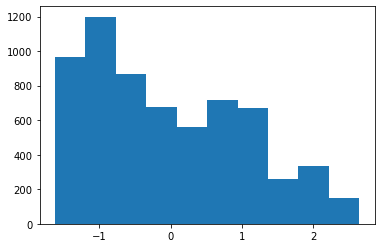

In [40]:
import matplotlib.pyplot as plt

plt.hist(strains[25])